In [161]:
%load_ext autoreload
%autoreload 2

from collections import deque
import matplotlib.pyplot as plt

import numpy as np
import torch 

import gym

from network import Network
from policy import Policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



_____________
#### Exploration de l'environnement

In [2]:
env = gym.make('CartPole-v0')

print(f'''
*** environnement : {env.spec} ***
\r\nobservation space : {env.observation_space}
action space : {env.action_space}
reward range : {env.reward_range}
''')


*** environnement : EnvSpec(CartPole-v0) ***

observation space : Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space : Discrete(2)
reward range : (-inf, inf)



#### Vanilla Hill Climbing

In [233]:
policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)
render = False
#---- hypp
SCALE = .5
N_EPISODE = 100
AVERAGE_ON_RECORD = 1
#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

best_score = 0

for i in range(N_EPISODE):

    done = False
    state = env.reset()
    score = 0
    
    while not done:
        if render:
            env.render()
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    
    if score >= best_score:
        best_score = score
        policy.best_w = policy.w
    
    policy.add_noise(SCALE)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()
    
if render:
    env.close()

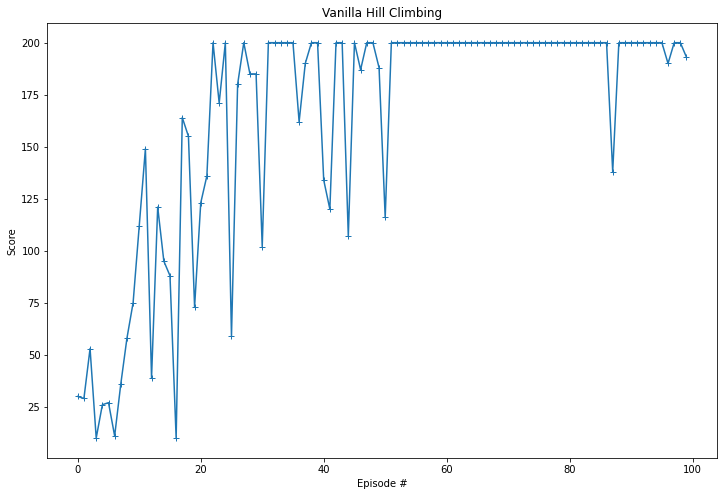

In [235]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Vanilla Hill Climbing')
plt.show()

#### Hill Climbing adaptative scaling

In [238]:
%%time

policy = Policy(state_size=4, action_size=2, hiden_layer_size=8)
render = False
AVERAGE_ON_RECORD = 1

#---- hypp
SCALE_INIT = .5
SCALE_UPDATE = 1.5
SCALE_MIN = 1e-4
SCALE_MAX = 2
N_EPISODE = 100
#----

scores_record = deque()
scores_window = deque(maxlen=AVERAGE_ON_RECORD)

scale = SCALE_INIT
best_score = 0

for i in range(N_EPISODE):

    done = False
    state = env.reset()
    score = 0
    
    while not done:
        if render:
            env.render()
        action = policy.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score += reward
    
    if score >= best_score:
        best_score = score
        policy.best_w = policy.w
        scale = max(scale / SCALE_UPDATE, SCALE_MIN)
    else:
        scale = min(scale * SCALE_UPDATE, SCALE_MAX)

    policy.add_noise(scale)
    
    scores_window.append(score)
    if len(scores_window) == AVERAGE_ON_RECORD:
        scores_record.append(np.mean(scores_window))
        scores_window = deque()
    
if render:
    env.close()

Wall time: 1.11 s


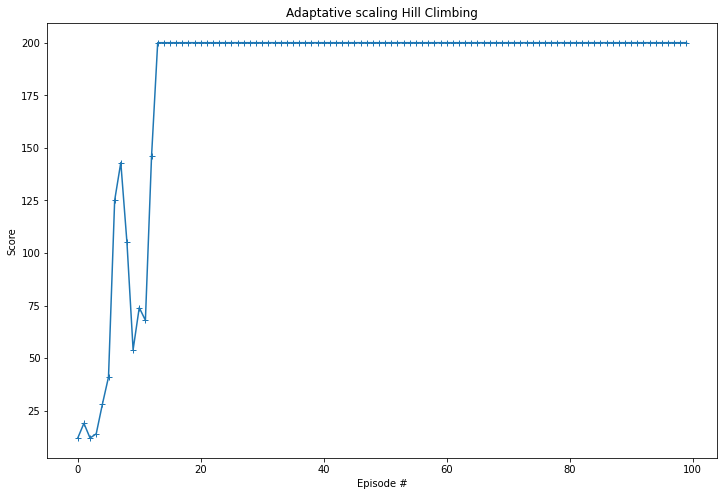

In [239]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores_record))*AVERAGE_ON_RECORD, scores_record, marker='+')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Adaptative scaling Hill Climbing')
plt.show()